In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import numpy
import torchvision
import torchvision.transforms.v2

train = torchvision.datasets.CIFAR10('cifar-10', train = True, download = False)
test = torchvision.datasets.CIFAR10('cifar-10', train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in tqdm.tqdm(train) ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]) for item in tqdm.tqdm(test) ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

100%|██████████| 10000/10000 [00:00<00:00, 46529.86it/s]


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [3]:
import joblib
import skimage.feature
import skimage.measure
import skimage.transform

def calc_daisy(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.feature.daisy)(
                img,
                step = 6,
                radius = 8,
                rings = 3,
                histograms = 8,
                orientations = 8
            )
            for img in tqdm.tqdm(gray_images, desc = "daisy")
        )
    ).reshape((len(gray_images), -1))

def calc_haar(gray_images, feature_type, feature_coord):
    def _calc(img, feature_type, feature_coord):
        ii = skimage.transform.integral_image(img)
        return skimage.feature.haar_like_feature(
            ii, 0, 0, ii.shape[0],  ii.shape[1],
            feature_type = feature_type, feature_coord = feature_coord
        )

    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(_calc)(img, feature_type, feature_coord)
            for img in tqdm.tqdm(gray_images, desc = "haar")
        )
    )

def calc_hessian(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.feature.hessian_matrix_det)(img)
            for img in tqdm.tqdm(gray_images, desc = "hessian")
        )
    ).reshape((len(gray_images), -1))

def calc_hog(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.feature.hog)(img)
            for img in tqdm.tqdm(gray_images, desc = "hog")
        )
    ).reshape((len(gray_images), -1))

def calc_basic(images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.feature.multiscale_basic_features)(
                img,
                sigma_min = 1,
                sigma_max = 1,
                num_sigma = 1
            )
            for img in tqdm.tqdm(images, desc = "basic")
        )
    ).reshape((len(images), -1))

def calc_shape_index(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.feature.shape_index)(img)
            for img in tqdm.tqdm(gray_images, desc = "shape_index")
        )
    ).reshape((len(gray_images), -1))

def calc_blur_effect(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.blur_effect)(img)
            for img in tqdm.tqdm(gray_images, desc = "blur_effect")
        )
    ).reshape((len(gray_images), -1))

def calc_centroid(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.centroid)(img)
            for img in tqdm.tqdm(gray_images, desc = "centroid")
        )
    ).reshape((len(gray_images), -1))

def calc_inertia_tensor(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.inertia_tensor)(img)
            for img in tqdm.tqdm(gray_images, desc = "inertia_tensor")
        )
    ).reshape((len(gray_images), -1))

def calc_moments(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.moments)(img)
            for img in tqdm.tqdm(gray_images, desc = "moments")
        )
    ).reshape((len(gray_images), -1))

def calc_moments_central(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.moments_central)(img)
            for img in tqdm.tqdm(gray_images, desc = "moments_central")
        )
    ).reshape((len(gray_images), -1))

def calc_moments_hu(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.moments_hu)(img)
            for img in tqdm.tqdm(gray_images, desc = "moments_hu")
        )
    ).reshape((len(gray_images), -1))

def calc_shannon_entropy(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.measure.shannon_entropy)(img)
            for img in tqdm.tqdm(gray_images, desc = "shannon_entropy")
        )
    ).reshape((len(gray_images), -1))

def calc_features(images):
    gray_images = numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(skimage.color.rgb2gray)(img)
            for img in tqdm.tqdm(images, desc = "rgb2gray")
        )
    )

    IV = numpy.load("17/IV.npy")
    feature_coord, feature_type = skimage.feature.haar_like_feature_coord(width=32, height=32)
    sel = numpy.argsort(IV)[::-1][:10000]
    feature_coord_sel = feature_coord[sel]
    feature_type_sel = feature_type[sel]
    del IV
    del feature_coord
    del feature_type

    return numpy.hstack([
        calc_daisy(gray_images),
        calc_haar(gray_images, feature_type_sel, feature_coord_sel),
        calc_hessian(gray_images),
        calc_hog(gray_images),
        calc_basic(gray_images), # images also works
        # calc_shape_index(gray_images), # has nans
        calc_blur_effect(gray_images),
        calc_centroid(gray_images),
        calc_inertia_tensor(gray_images),
        calc_moments(gray_images),
        calc_moments_central(gray_images),
        calc_moments_hu(gray_images),
        calc_shannon_entropy(gray_images),
    ])

In [4]:
train_gray = numpy.stack(
    joblib.Parallel(n_jobs = -1)(
        joblib.delayed(skimage.color.rgb2gray)(img)
        for img in tqdm.tqdm(train_images, desc = "rgb2gray")
    )
)

test_gray = numpy.stack(
    joblib.Parallel(n_jobs = -1)(
        joblib.delayed(skimage.color.rgb2gray)(img)
        for img in tqdm.tqdm(test_images, desc = "rgb2gray")
    )
)

rgb2gray: 100%|██████████| 10000/10000 [00:00<00:00, 34186.89it/s]


In [16]:
def calc_stats(data):
    return numpy.array([
        numpy.trapz(data), # integral
        numpy.sum(numpy.abs(data)), # manhattan norm
        numpy.sqrt(numpy.sum(data ** 2)), # euclidean norm
        numpy.max(numpy.abs(data)), # infinity norm
    ])

def _calc(gray_image):
    thresholds = list(range(256))
    euler_numbers, area, perimeter, perimeter_crofton = [], [], [], []
    for threshold in thresholds:
        bin = (gray_image > threshold)
        euler_numbers.append(skimage.measure.euler_number(bin))
        area.append(bin.sum())
        perimeter.append(skimage.measure.perimeter(bin))
        perimeter_crofton.append(skimage.measure.perimeter_crofton(bin))
    euler_numbers = numpy.array(euler_numbers)
    area = numpy.array(area)
    perimeter = numpy.array(perimeter)
    perimeter_crofton = numpy.array(perimeter_crofton)
    

    return numpy.concatenate([
        calc_stats(euler_numbers),
        calc_stats(area),
        calc_stats(perimeter),
        calc_stats(perimeter_crofton),
        calc_stats(numpy.diff(euler_numbers)),
        calc_stats(numpy.diff(area)),
        calc_stats(numpy.diff(perimeter)),
        calc_stats(numpy.diff(perimeter_crofton))
    ])

def calc_curvature(gray_images):
    return numpy.stack(
        joblib.Parallel(n_jobs = -1)(
            joblib.delayed(_calc)(img)
            for img in tqdm.tqdm(gray_images, desc = "curvature")
        )
    ).reshape((len(gray_images), -1))

In [17]:
train_curvature = calc_curvature(train_gray)
test_curvature = calc_curvature(test_gray)

train_curvature.shape, test_curvature.shape

curvature: 100%|██████████| 10000/10000 [00:59<00:00, 169.40it/s]


((50000, 32), (10000, 32))

In [8]:
train_X = calc_haar(train_gray[:5000])
train_y = train_labels[:5000]
numpy.save("17/train_X.npy", train_X)

print(train_X.shape, train_y.shape)

test_X = calc_haar(test_gray[:1000])
test_y = test_labels[:1000]
numpy.save("17/test_X.npy", test_X)

print(test_X.shape, test_y.shape)

(5000, 510112) (5000,)


haar: 100%|██████████| 1000/1000 [01:20<00:00, 12.42it/s]


(1000, 510112) (1000,)


In [4]:
del train_images
del test_images

In [24]:
train_X = numpy.load("17/train_X.npy")
train_y = train_labels
print(train_X.shape, train_y.shape)

test_X = numpy.load("17/test_X.npy")
test_y = test_labels
print(test_X.shape, test_y.shape)

(5000, 510112) (50000,)
(1000, 510112) (10000,)


In [8]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.1, bins = 50)
feature_selector.fit(train_X, train_y)
numpy.argsort(feature_selector.IV_)[::-1][:50]

Fitting the information value feature selector


information values: 100%|██████████| 510112/510112 [09:13<00:00, 922.24it/s] 

Fitting complete


array([136650, 146657, 195707, 136649, 137114, 137564, 153365, 137563,
       154161, 145442, 135673, 152447, 136168, 137562, 196045, 137112,
       146658, 137995, 137566, 137993, 137115, 147032, 152009, 224586,
       153756, 137089, 223312, 153332, 224350, 152898, 136169, 146659,
       137090, 144095, 138411, 145863, 137117, 152896, 161131, 159869,
       137565, 145862, 145864, 195356, 136654, 168116, 137561, 153334,
       137111, 136174], dtype=int64)

In [18]:
numpy.save("17/IV.npy", feature_selector.IV_)

In [ ]:
IV = numpy.load("17/IV.npy")

feature_coord, feature_type = skimage.feature.haar_like_feature_coord(width=32, height=32)

sel = numpy.argsort(IV)[::-1][:10000]

feature_coord_sel = feature_coord[sel]
feature_type_sel = feature_type[sel]

In [7]:
feature_coord, feature_type = skimage.feature.haar_like_feature_coord(width=32, height=32)
feature_coord.shape, feature_type.shape

((510112,), (510112,))

In [ ]:
sel = numpy.argsort(IV)[::-1][:10000]
feature_coord_sel = feature_coord[sel]
feature_type_sel = feature_type[sel]
feature_coord_sel.shape, feature_type_sel.shape

((25000,), (25000,))

In [17]:
train_X = calc_haar(train_gray, feature_type_sel, feature_coord_sel)
train_y = train_labels

print(train_X.shape, train_y.shape)

test_X = calc_haar(test_gray, feature_type_sel, feature_coord_sel)
test_y = test_labels

print(test_X.shape, test_y.shape)

haar: 100%|██████████| 50000/50000 [27:28<00:00, 30.34it/s]


(50000, 25000) (50000,)


haar: 100%|██████████| 10000/10000 [03:00<00:00, 55.34it/s]


(10000, 25000) (10000,)


In [19]:
import sklearn.preprocessing

standard_scaler = sklearn.preprocessing.StandardScaler(copy = False)
train_X = standard_scaler.fit_transform(train_X)
test_X = standard_scaler.transform(test_X)

In [15]:
import cvtda.utils

duplicates_remover = cvtda.utils.DuplicateFeaturesRemover()
train_X = duplicates_remover.fit_transform(train_X)
test_X = duplicates_remover.transform(test_X)

train_X.shape, test_X.shape

100%|██████████| 5000/5000 [00:09<00:00, 535.70it/s, partition_by=0, num_features=1, duplicates=0]


Found 0 duplicates


((50000, 5000), (10000, 5000))

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=4, max_features='sqrt', n_jobs=-1, random_state=42, verbose = 2)
rf.fit(train_X, train_y)
numpy.argsort(rf.feature_importances_)[::-1][:50]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 1000building tree 2 of 1000

building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s


building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   40.8s


building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.7min


building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  3.1min


building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000building tree 660 of 1000

building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished


array([ 123,    5,  396, 1894,  212,  145,   40,  130,  131,  273,  268,
         55,  271,   36,  909,  185,  237,  202,    7,  196,   20,   49,
        231,   11,   47,  429,  326,  178,  102,    0,   52,   25,  105,
        174,  236,  841,  256,  791, 1718,   57, 1287,  405,  250,  532,
         51,  304, 1066,  190,  337,   88], dtype=int64)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


{'Accuracy': 0.2616,
 'TOP-2 Accuracy': 0.4327,
 'TOP-3 Accuracy': 0.5644,
 'TOP-4 Accuracy': 0.6659,
 'TOP-5 Accuracy': 0.7564,
 'TOP-6 Accuracy': 0.8234,
 'TOP-7 Accuracy': 0.8792,
 'TOP-8 Accuracy': 0.9268,
 'TOP-9 Accuracy': 0.9676,
 'AUC-ROC': 0.7187627555555556,
 'Precision': 0.2682233179988202,
 'Recall': 0.2616,
 'F1-score': 0.22950263683149918}

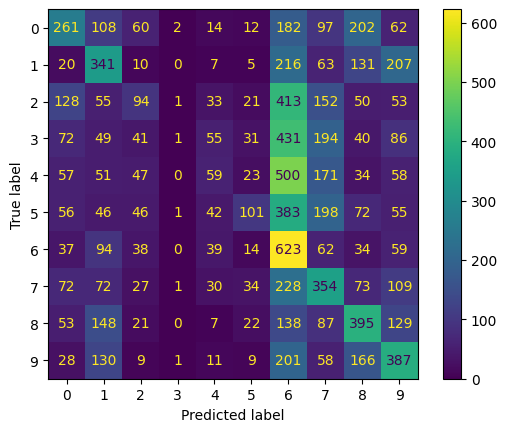

In [21]:
import cvtda.classification

cvtda.classification.estimate_quality(
    rf.predict_proba(test_X),
    test_y
)

In [ ]:
cvtda.classification.classify(
    train_X, train_y, test_X, test_y
)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3048, 'TOP-2 Accuracy': 0.495, 'TOP-3 Accuracy': 0.6202, 'TOP-4 Accuracy': 0.7205, 'TOP-5 Accuracy': 0.802, 'TOP-6 Accuracy': 0.857, 'TOP-7 Accuracy': 0.9043, 'TOP-8 Accuracy': 0.9438, 'TOP-9 Accuracy': 0.9749, 'AUC-ROC': 0.7633219111111111, 'Precision': 0.3500385321752953, 'Recall': 0.30480000000000007, 'F1-score': 0.2953181528004612}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3902, 'TOP-2 Accuracy': 0.5732, 'TOP-3 Accuracy': 0.6969, 'TOP-4 Accuracy': 0.7852, 'TOP-5 Accuracy': 0.8417, 'TOP-6 Accuracy': 0.8907, 'TOP-7 Accuracy': 0.9289, 'TOP-8 Accuracy': 0.9585, 'TOP-9 Accuracy': 0.9807, 'AUC-ROC': 0.8042692500000002, 'Precision': 0.3867404069195165, 'Recall': 0.3902, 'F1-score': 0.3865931313134777}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001979900ACE0>
Input to LazyLinear: 250

100%|██████████| 25/25 [01:27<00:00,  3.48s/it, loss=1.04e+5, val_acc=0.392]


{'classifier': 'NNClassifier', 'Accuracy': 0.3922, 'TOP-2 Accuracy': 0.5824, 'TOP-3 Accuracy': 0.6981, 'TOP-4 Accuracy': 0.7831, 'TOP-5 Accuracy': 0.8459, 'TOP-6 Accuracy': 0.8942, 'TOP-7 Accuracy': 0.9302, 'TOP-8 Accuracy': 0.9592, 'TOP-9 Accuracy': 0.9809, 'AUC-ROC': 0.7945992444444443, 'Precision': 0.3888751484369004, 'Recall': 0.3922, 'F1-score': 0.3840436454197488}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3696, 'TOP-2 Accuracy': 0.5615, 'TOP-3 Accuracy': 0.683, 'TOP-4 Accuracy': 0.7751, 'TOP-5 Accuracy': 0.8443, 'TOP-6 Accuracy': 0.896, 'TOP-7 Accuracy': 0.9352, 'TOP-8 Accuracy': 0.9657, 'TOP-9 Accuracy': 0.9847, 'AUC-ROC': 0.7990631666666668, 'Precision': 0.37031149281966214, 'Recall': 0.3696, 'F1-score': 0.36451276452870784}
Fitting <catboost.core.CatBoostClassifier object at 0x0000019799008760>
Learning rate set to 0.309284
0:	

In [ ]:
train_X = calc_features(train_images)
test_X = calc_features(test_images)

train_X.shape, test_X.shape

haar:   1%|          | 388/50000 [00:31<1:26:23,  9.57it/s]

KeyboardInterrupt: 

haar:   1%|          | 388/50000 [00:44<1:26:23,  9.57it/s]

In [4]:
train_X = calc_features(train_images)
test_X = calc_features(test_images)

train_X.shape, test_X.shape

shannon_entropy: 100%|██████████| 10000/10000 [00:00<00:00, 23201.88it/s]


((50000, 17291), (10000, 17291))

In [23]:
train_features = numpy.hstack([
    train_images.reshape((len(train_images), -1)),
    train_X,
    train_curvature,
    *[
        numpy.load(f"E:/{id}/{channel}/{split}/train.npy")
        for id in [ "2", "4", "6", "8" ]
        for split in [ "None" ]
        for channel in [ "red", "green", "blue", "inv_red", "inv_green", "inv_blue" ]
    ]
])

test_features = numpy.hstack([
    test_images.reshape((len(test_images), -1)),
    test_X,
    test_curvature,
    *[
        numpy.load(f"E:/{id}/{channel}/{split}/test.npy")
        for id in [ "2", "4", "6", "8" ]
        for split in [ "None" ]
        for channel in [ "red", "green", "blue", "inv_red", "inv_green", "inv_blue" ]
    ]
])

train_features.shape, test_features.shape

NameError: name 'train_X' is not defined

Fitting the information value feature selector


information values: 100%|██████████| 62363/62363 [16:09<00:00, 64.32it/s] 


Fitting complete


(array([8.160e+02, 1.920e+03, 2.164e+03, 3.392e+03, 4.143e+03, 5.068e+03,
        4.894e+03, 4.324e+03, 4.168e+03, 3.776e+03, 3.112e+03, 2.774e+03,
        2.582e+03, 2.085e+03, 1.638e+03, 1.823e+03, 2.280e+03, 2.772e+03,
        2.638e+03, 2.457e+03, 1.612e+03, 3.720e+02, 2.640e+02, 2.820e+02,
        3.130e+02, 1.200e+02, 1.850e+02, 9.500e+01, 3.500e+01, 4.000e+01,
        4.900e+01, 2.000e+01, 4.900e+01, 2.100e+01, 3.200e+01, 4.000e+00,
        1.200e+01, 4.000e+00, 5.000e+00, 1.000e+00, 5.000e+00, 4.000e+00,
        1.000e+00, 0.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.01338813, 0.02677627, 0.0401644 , 0.05355253,
        0.06694067, 0.0803288 , 0.09371693, 0.10710507, 0.1204932 ,
        0.13388133, 0.14726947, 0.1606576 , 0.17404573, 0.18743387,
        0.200822  , 0.21421013, 0.22759827, 0.2409864 , 0.25437453,
        0.26776267, 0.2811508 , 0.29453893, 0.30792707, 0.3213152 ,
        0.33470333, 0.34809147, 0.36

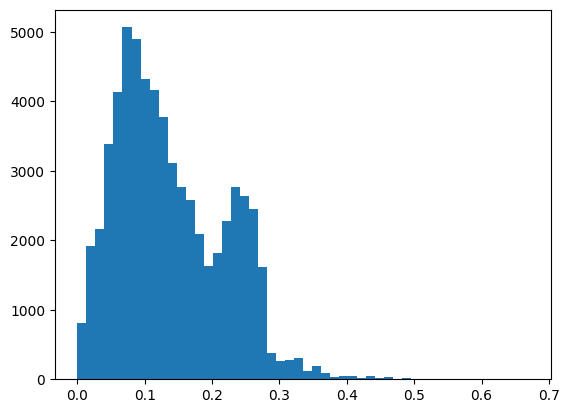

In [9]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.15, bins = 50)
feature_selector.fit(train_features, train_labels)
feature_selector.hist()

In [11]:
train_features = feature_selector.transform(train_features)
test_features = feature_selector.transform(test_features)

In [12]:
import gc
gc.collect()

93

In [18]:
train_features = train_curvature.copy()
test_features = test_curvature.copy()

In [19]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler(copy = False)
train_features = selected_standard_scaler.fit_transform(train_features)
test_features = selected_standard_scaler.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.1083, 'TOP-2 Accuracy': 0.2093, 'TOP-3 Accuracy': 0.3076, 'TOP-4 Accuracy': 0.4071, 'TOP-5 Accuracy': 0.5092, 'TOP-6 Accuracy': 0.6003, 'TOP-7 Accuracy': 0.7017, 'TOP-8 Accuracy': 0.8004, 'TOP-9 Accuracy': 0.8999, 'AUC-ROC': 0.506603311111111, 'Precision': 0.09605093868224365, 'Recall': 0.1083, 'F1-score': 0.0379208190195108}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.1092, 'TOP-2 Accuracy': 0.2153, 'TOP-3 Accuracy': 0.3195, 'TOP-4 Accuracy': 0.4216, 'TOP-5 Accuracy': 0.5212, 'TOP-6 Accuracy': 0.6205, 'TOP-7 Accuracy': 0.7198, 'TOP-8 Accuracy': 0.8162, 'TOP-9 Accuracy': 0.9092, 'AUC-ROC': 0.51263735, 'Precision': 0.1274648319191233, 'Recall': 0.10919999999999999, 'F1-score': 0.039463360247266877}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x0000021AA9FCE170>
Input to LazyLinear: 32
Par

100%|██████████| 25/25 [00:31<00:00,  1.24s/it, loss=1.15e+5, val_acc=0.109]


{'classifier': 'NNClassifier', 'Accuracy': 0.1094, 'TOP-2 Accuracy': 0.2163, 'TOP-3 Accuracy': 0.3206, 'TOP-4 Accuracy': 0.4215, 'TOP-5 Accuracy': 0.5229, 'TOP-6 Accuracy': 0.6203, 'TOP-7 Accuracy': 0.7166, 'TOP-8 Accuracy': 0.8146, 'TOP-9 Accuracy': 0.9092, 'AUC-ROC': 0.5136417944444445, 'Precision': 0.04617445530798957, 'Recall': 0.10939999999999998, 'F1-score': 0.03611225282689271}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.1113, 'TOP-2 Accuracy': 0.2178, 'TOP-3 Accuracy': 0.3217, 'TOP-4 Accuracy': 0.423, 'TOP-5 Accuracy': 0.5238, 'TOP-6 Accuracy': 0.6224, 'TOP-7 Accuracy': 0.7208, 'TOP-8 Accuracy': 0.8171, 'TOP-9 Accuracy': 0.9107, 'AUC-ROC': 0.5150420222222223, 'Precision': 0.14964334420042472, 'Recall': 0.1113, 'F1-score': 0.040152033981553745}
Fitting <catboost.core.CatBoostClassifier object at 0x0000021AA9FCE260>
Learning rate se

d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'classifier': 'XGBClassifier', 'Accuracy': 0.1103, 'TOP-2 Accuracy': 0.2169, 'TOP-3 Accuracy': 0.3205, 'TOP-4 Accuracy': 0.4221, 'TOP-5 Accuracy': 0.5229, 'TOP-6 Accuracy': 0.6226, 'TOP-7 Accuracy': 0.7213, 'TOP-8 Accuracy': 0.8166, 'TOP-9 Accuracy': 0.9107, 'AUC-ROC': 0.5148978777777777, 'Precision': 0.08794628736415556, 'Recall': 0.11029999999999998, 'F1-score': 0.03829512066917512}


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.1083,0.2093,0.3076,0.4071,0.5092,0.6003,0.7017,0.8004,0.8999,0.506603,0.096051,0.1083,0.037921
1,RandomForestClassifier,0.1092,0.2153,0.3195,0.4216,0.5212,0.6205,0.7198,0.8162,0.9092,0.512637,0.127465,0.1092,0.039463
2,NNClassifier,0.1094,0.2163,0.3206,0.4215,0.5229,0.6203,0.7166,0.8146,0.9092,0.513642,0.046174,0.1094,0.036112
3,HistGradientBoostingClassifier,0.1113,0.2178,0.3217,0.4230,0.5238,0.6224,0.7208,0.8171,0.9107,0.515042,0.149643,0.1113,0.040152
4,CatBoostClassifier,0.1107,0.2174,0.3207,0.4225,0.5213,0.6209,0.7196,0.8160,0.9100,0.514086,0.144712,0.1107,0.040577
5,XGBClassifier,0.1103,0.2169,0.3205,0.4221,0.5229,0.6226,0.7213,0.8166,0.9107,0.514898,0.087946,0.1103,0.038295


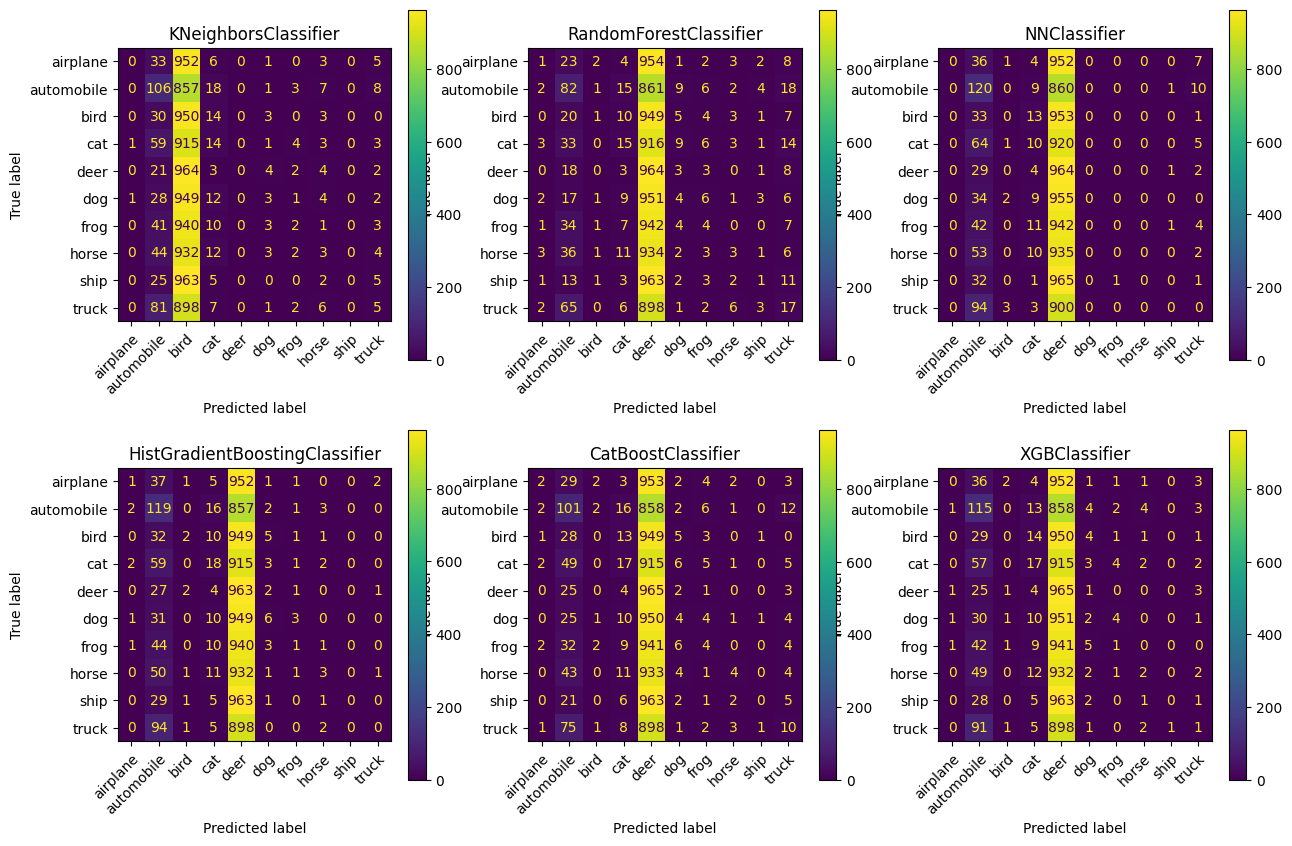

In [22]:
import cvtda.classification
import matplotlib.pyplot as plt

display(cvtda.classification.classify(train_features, train_labels, test_features, test_labels, label_names = test.classes))

for ax in plt.gcf().axes:
    ax.set_xticks(ax.get_xticks(), labels = ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")